# TF-IDF + XGBClassifier for Sentiment Analysis

## Import Libraries

In [2]:
# Common Python Libraries
import numpy as np
import pandas as pd
import os
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import random

# for cleaner output
from tqdm import tqdm

# Word Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

# Data Preprocessing
from sklearn.model_selection import train_test_split

# model
from xgboost import XGBClassifier

# Grid search
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Project path
project_path = "../"

# Project Seed for Reproducability
SEED = random.randint(0, 2**32 - 1)  # Random integer between 0 and 2^32-1
print(SEED)

589970554


## Import Data

In [3]:
data = pd.read_csv(os.path.join(project_path,"Data/CleanData.csv"))
data = data.dropna().drop_duplicates().reset_index(drop=True)

In [4]:
data.head(10)

,text,label
0,halo bunda bunda hadap 2 pilih pilih 1 hasil 5...,0
1,caci maki keluarga caci maki kerabat mantan pa...,0
2,semangat bunda cari kerja pisah beda prinsip c...,0
3,om atur 50 ribu hari hidup desa giat acara haj...,0
4,mohon izin curhat ayah mertua ayah mertua saya...,2
5,jalan 3 nikah ldr muak banget teman obrol,0
6,saran hadap hobi main main kadang on perempuan...,0
7,daerah bekas bekas teman,0
8,hancur percaya malu mati penuh trauma kecewa,2
9,assalamualaikum mohon saran nama usia pt statu...,2


## Train Test Split

In [5]:
test_size = 0.20
val_size = 0.10

# Splitting the data into train and temp (which will be further split into validation and test)
train_df, test_df = train_test_split(data, test_size=test_size, random_state=SEED)

# Splitting train into validation and test sets
train_df, val_df = train_test_split(train_df, test_size=val_size, random_state=SEED)

In [6]:
x_train = train_df["text"]
x_test = test_df["text"]
x_val = val_df["text"]


y_train = train_df["label"]
y_test = test_df["label"]
y_val = val_df["label"]

## Word Embedding

In [7]:
# pass the cleaned text to the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100000)  # you can change this limit
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)
x_val_tfidf = tfidf_vectorizer.transform(x_val)

In [8]:
print("Vocabulary size:", len(tfidf_vectorizer.get_feature_names_out()))
print("tfidf shape (train):", x_train_tfidf.shape)
print("tfidf shape (test):", x_test_tfidf.shape)
print("tfidf shape (val):", x_val_tfidf.shape)

Vocabulary size: 3309
tfidf shape (train): (1552, 3309)
tfidf shape (test): (432, 3309)
tfidf shape (val): (173, 3309)


## Modelling

### TF-IDF Xgboost Classifier

#### Grid Search Setup

In [9]:
# Default Parameters
xgbClassifier_model = XGBClassifier(verbosity=1,                # just show warnings
                                    objective="multi:softprob", # Since this is multi-class classification
                                    importance_type='gain',      # calculates the relative contribution of a feature to all the trees in a model
                                    random_state = SEED
                                    # tree_method="hist"          # GPU Training
                                    )

# Grid search setup
gr_space = {
    'booster': ['gbtree'],                      # tree based models
    'max_depth': [4, 8, 16, 32],              # The maximum depth of the trees (bigger depth may make the model ovexgbClassifierit)
    'n_estimators': [100, 200],            # number of trees
    'learning_rate': [0.05, 0.075, 0.1]          # learning rate of the model
}

xgbClassifier_model_grid = GridSearchCV(xgbClassifier_model,
                            gr_space,
                            cv = 3,
                            scoring='f1_weighted',
                            verbose = 2,
                            n_jobs=-1 #for all cores in cpu (use 1 for gpu training)
                            )

#### Initiate Training

In [10]:
tfIDF_XGBC_model_result = xgbClassifier_model_grid.fit(x_train_tfidf, y_train)

print("Training tfIDF_XGBC Model Done")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END booster=gbtree, learning_rate=0.05, max_depth=4, n_estimators=100; total time=   2.0s
[CV] END booster=gbtree, learning_rate=0.05, max_depth=4, n_estimators=100; total time=   3.3s
[CV] END booster=gbtree, learning_rate=0.05, max_depth=4, n_estimators=100; total time=   3.4s
[CV] END booster=gbtree, learning_rate=0.05, max_depth=4, n_estimators=200; total time=   4.2s
[CV] END booster=gbtree, learning_rate=0.05, max_depth=4, n_estimators=200; total time=   6.1s
[CV] END booster=gbtree, learning_rate=0.05, max_depth=4, n_estimators=200; total time=   6.9s
[CV] END booster=gbtree, learning_rate=0.05, max_depth=8, n_estimators=100; total time=   8.2s
[CV] END booster=gbtree, learning_rate=0.05, max_depth=8, n_estimators=200; total time=   9.0s
[CV] END booster=gbtree, learning_rate=0.05, max_depth=8, n_estimators=100; total time=   8.6s
[CV] END booster=gbtree, learning_rate=0.075, max_depth=4, n_estimators=100; total t

#### Model Evaluation

In [11]:
model_path = os.path.join(project_path,"models/tfIDF_XGBC_model_result.pkl")
seed_path = os.path.join(project_path,"models/tfIDF_XGBC_model_SEED.txt")

# Make sure the folder exists
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Evaluate new model
tfIDF_XGBC_prediction = tfIDF_XGBC_model_result.predict(x_test_tfidf)
new_f1 = f1_score(y_test, tfIDF_XGBC_prediction, average="weighted", zero_division=0)  # weighted average since each class maybe not sampled when splitting

# Check if previous model exists
if os.path.exists(model_path):
    with open(model_path, "rb") as f:
        old_model = joblib.load(f)

    old_prediction = old_model.predict(x_test_tfidf)
    old_f1 = f1_score(y_test, old_prediction, average="weighted", zero_division=0)

    print(f"Old F1: {old_f1:.4f} | New F1: {new_f1:.4f}")

    if new_f1 > old_f1:
        print("🔁 New model is better — overwriting saved model.")
        with open(model_path, "wb") as f:
            joblib.dump(tfIDF_XGBC_model_result, f)
        with open(seed_path, "w") as file:
            file.write(str(SEED))
    else:
        print("✅ Existing model is still better.")
        tfIDF_XGBC_model_result = old_model
else:
    # No model saved yet
    print("📥 No existing model — saving new model.")
    with open(model_path, "wb") as f:
        joblib.dump(tfIDF_XGBC_model_result, f)
    with open(seed_path, "w") as file:
        file.write(str(SEED))

📥 No existing model — saving new model.


##### Classification Report

In [12]:
tfIDF_XGBC_prediction = tfIDF_XGBC_model_result.predict(x_test_tfidf)
print(classification_report(y_test, tfIDF_XGBC_prediction, zero_division=0))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       300
           1       0.88      0.79      0.83        75
           2       0.95      0.61      0.74        57

    accuracy                           0.90       432
   macro avg       0.91      0.79      0.84       432
weighted avg       0.90      0.90      0.89       432



##### Confusion Matrix

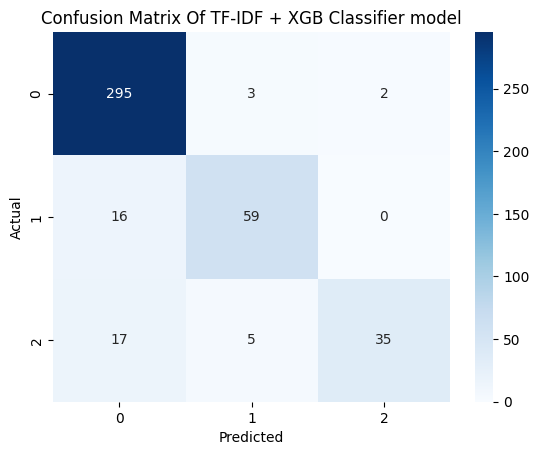

In [15]:


tfIDF_XGBC_cm = pd.DataFrame(confusion_matrix(y_test,
                                            tfIDF_XGBC_prediction))

sns.heatmap(
    tfIDF_XGBC_cm,
    cmap= "Blues",
    annot= True,
    fmt= "g"
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Of TF-IDF + XGB Classifier model")

plt.show()